# Introduction to the tg_mrf_optimization package

This notebook is intended as a short introduction to the tg_mrf_optimization package, which can be used to simulate MRF signal courses and optimize MRF sequences.

Tom Griesler, 05/24

tomgr@umich.edu

## Sequence Definition

The flip angles and repetition times as used by Cao (MRM 2022) will serve as reference and initialization for the optimization. 

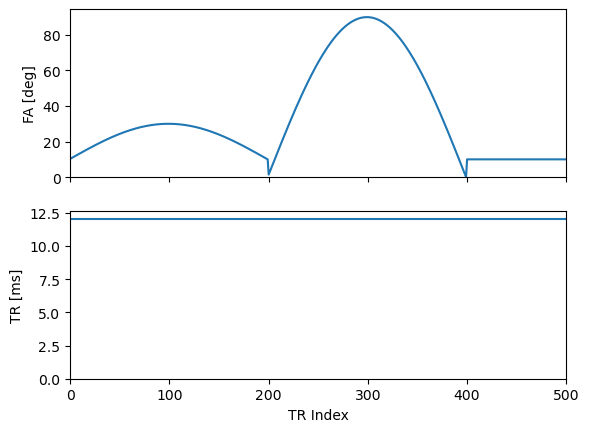

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fa = np.load('initialization/fa_cao.npy')
tr = np.load('initialization/tr_cao.npy')

# We use constant excitation phase
ph = np.zeros_like(fa)

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(fa)
ax[0].set_xlim(0, len(fa))
ax[0].set_ylim(0)
ax[0].set_ylabel('FA [deg]')

ax[1].plot(tr)
ax[1].set_ylim(0)
ax[1].set_xlabel('TR Index')
ax[1].set_ylabel('TR [ms]')

plt.show()


The way sequences are defined in this package is taylored towards cardiac MRF sequences which typically consist of multiple magnetization prepared readout blocks, but can of course also be used for simpler MRF sequences. A sequence is fully defined by the following parameters: 
- beats: number of readout blocks
- shots: number of excitations per readout block
- fa: flip angles
- tr: repetition times
- ph: excitation phases
- prep: list of integers that define the magnetization preparations before the readout blocks. 0: no preparation. 1: inversion. 2: T2 preparation. The length of prep has to be equal to beats.
- ti: list of inversion times. Set to zero if the corresponding entry of prep is not 1. 
- t2te: list of T2 preparation times. Set to zero if the corresponding entry of prep is not 2. 
- te: echo time

In the following, we will stick to the "default" case of an MRF-FISP sequence preceded by a a single inversion pulse, subsequent delay of 20 ms, and no additional magnetization preparations. Thus, we simply set

In [2]:
beats = 1
shots = len(fa)
prep = [1]
ti = [20]
t2te = [0]

## Signal Simulation

All signal simulation and cost function calculation code has been implemented both using Bloch simulations/isochromat summation and EPG simulations. Throughout the remainder of this tutorial, we will only use the EPG version. See iso_vs_epg.ipynb for a comparison of the approaches. 

For the signal simulation, we first define an example tissue.

In [3]:
t1 = 1000 # T1 in ms 
t2 = 100 # T2 in ms
m0 = 1

Furthermore, we define the echo time, inversion efficiency and B1 correction factor.

In [4]:
te = 1
inv_eff = 1 # Assume perfect inversion
delta_B1 = 1 # Assume perfect B1 transmission

Calculate and plot the signal.

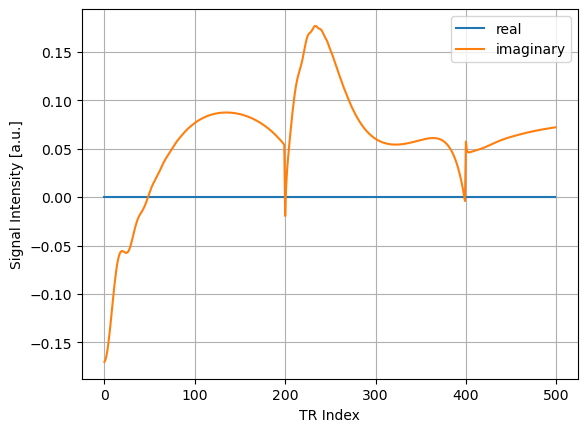

In [5]:
from signalmodel_epg import calculate_signal_fisp_epg

signal_epg = calculate_signal_fisp_epg(t1, t2, m0, beats, shots, fa, tr, ph, prep, ti, t2te, te, inv_eff=inv_eff, delta_B1=delta_B1)

plt.plot(np.real(signal_epg), label='real')
plt.plot(np.imag(signal_epg), label='imaginary')
plt.grid()
plt.legend()
plt.xlabel('TR Index')
plt.ylabel('Signal Intensity [a.u.]')
plt.show()

## Sequence Optimization

In this package, three cost functions can be used for sequence optimization: 
- single component CRLB: aims at minimizing the variance of T1, T2, and M0 in a single component setting
- multi component CRLB: aims at minimizing the variance of the tissue fraction in a two component setting
- orthogonality: aims at increasing the discrimination of different tissues in a multi component setting

All cost functions are implemented for both the isochromat summation and EPG approach.

The optimization process is the same for all cost functions. At every step, the gradients of the cost function with respect to all input flip angles and repetition times are automatically calculated using backpropagation. Then, the flip angles and repetition times are updated using the SLSQP algorithm. 

Example optimization using the single component CRLB cost function:

In [7]:
from slsqp import optimize_sequence

# Set cost function to single component CRLB with EPG
costfunction = 'crlb_sc_epg'

# Flip angle constraints
fa_min = 10 # deg
fa_max = 60 # deg
fa_maxdiff = 1 # deg

# Repetition time constraints
tr_min = 8 # ms
tr_max = 16 # ms

# Other optimization parameters
n_iter_max = 500 # maximum number of iterations
weighting = [1/t1, 1/t2, 1/m0] # weighting of the standard deviations of T1, T2, and M0 in the cost function

# Run optimization
fa_final, tr_final, = optimize_sequence(costfunction, t1, t2, m0, beats, shots, fa, tr, ph, prep, ti, t2te, te, fa_min, fa_max, fa_maxdiff, n_iter_max, weighting=weighting, optimize_tr=True, tr_min=tr_min, tr_max=tr_max, inv_eff=inv_eff, delta_B1=delta_B1, acc=1e-3)

  NIT    FC           OBJFUN            GNORM
    1     2     3.606089E+03     9.806891E+00
    2     3     3.375359E+03     9.128266E+00
    3     4     3.158110E+03     7.779968E+00
    4     5     3.062638E+03     6.718882E+00
    5     6     2.995437E+03     6.413268E+00
    6     7     2.955241E+03     6.529937E+00
    7     8     2.956468E+03     7.224696E+00
    8     9     3.015185E+03     9.288241E+00
    9    10     3.012417E+03     1.069897E+01


Example optimization using the multi component CRLB cost function:

In [ ]:
# Set cost function to single component CRLB with EPG
costfunction = 'crlb_mc_epg'

# Define target voxel containing two different tissues
t1 = [1000, 200] # T1 of first and second tissue
t2 = [100, 20] # T2 of first and second tissue
ratio = 0.5 # ratio of first to second tissue

# Flip angle constraints
fa_min = 10 # deg
fa_max = 60 # deg
fa_maxdiff = 1 # deg

# Repetition time constraints
tr_min = 8 # ms
tr_max = 16 # ms

# Other optimization parameters
n_iter_max = 500 # maximum number of iterations

# Run optimization
fa_final, tr_final, = optimize_sequence(costfunction, t1, t2, m0, beats, shots, fa, tr, ph, prep, ti, t2te, te, fa_min, fa_max, fa_maxdiff, n_iter_max, ratio=ratio, optimize_tr=True, tr_min=tr_min, tr_max=tr_max)

Example optimization using the tissue discrimination cost function:

In [ ]:
# Set cost function to single component CRLB with EPG
costfunction = 'crlb_orth_epg'

# Flip angle constraints
fa_min = 10 # deg
fa_max = 60 # deg
fa_maxdiff = 1 # deg

# Repetition time constraints
tr_min = 8 # ms
tr_max = 16 # ms

# Other optimization parameters
n_iter_max = 500 # maximum number of iterations

# Run optimization
fa_final, tr_final, = optimize_sequence(costfunction, t1, t2, m0, beats, shots, fa, tr, ph, prep, ti, t2te, te, fa_min, fa_max, fa_maxdiff, n_iter_max, slsqp_scaling=1e4, optimize_tr=True, tr_min=tr_min, tr_max=tr_max)